# Quality Assurance (QA) Tutorial

This notebook gives example uses of image based QA metrics in `ukat`.

We'll start with some imports and general housekeeping

In [7]:
import sys
sys.path.append('/Users/spmic/Documents/MATLAB/qa/')
print(sys.path)

import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib


#from ukat.data import fetch
from fMRI_report_python.functions import snr
#from fMRI_report_python.functions.snr import some_function
#from functions import snr

# check packages
print(snr)
print(dir(snr))

['/Users/spmic/Documents/MATLAB/qa/fMRI_report_python/tutorials', '/Users/spmic/fsl/lib/python311.zip', '/Users/spmic/fsl/lib/python3.11', '/Users/spmic/fsl/lib/python3.11/lib-dynload', '', '/Users/spmic/fsl/lib/python3.11/site-packages', '/Users/spmic/Documents/MATLAB/qa/', '/Users/spmic/Documents/MATLAB/qa/', '/Users/spmic/Documents/MATLAB/qa/', '/Users/spmic/Documents/MATLAB/qa/', '/Users/spmic/Documents/MATLAB/qa/']
<module 'fMRI_report_python.functions.snr' from '/Users/spmic/Documents/MATLAB/qa/fMRI_report_python/functions/snr.py'>
['BayesianGaussianMixture', 'Isnr', 'Tsnr', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'nib', 'np', 'os']


In [13]:
def load_data(inputdatafilename):
    #Function to load in data 
    #Needs an input arg
    data = nib.load(inputdatafilename)
    image = data.get_fdata()
    return image, data.affine

In [41]:
# Initialise output path for QA
directory = 'qa_output'
os.makedirs(directory, exist_ok=True)
OUTPUT_DIR = os.path.join(os.getcwd(), directory)
print(OUTPUT_DIR)

# filenames
pathname = '/Users/spmic/Documents/MATLAB/qa/fMRI_report_python/data/'
filename_cla = 'FUNSTAR_classic_SM_MB0_17slc_1p25mm_iso_TR2'
filename_mtx = 'FUNSTAR_mtx_SM_MB0_1p25mm_iso_TR2'

filename_cla_p = pathname+'/'+filename_cla
filename_mtx_p = pathname+'/'+filename_mtx

# load data
imgm_cla, imgm_cla_affine = load_data(filename_cla_p+'.nii')
imgm_mtx, imgm_mtx_affine = load_data(filename_mtx_p+'.nii')
imgp_cla, imgp_cla_affine = load_data(filename_cla_p+'_ph.nii')
imgp_mtx, imgp_mtx_affine = load_data(filename_mtx_p+'_ph.nii')

print("Image data shape:", imgm_cla.shape)
print("Affine matrix:")
print(imgm_cla_affine)

print("Image data shape:", imgm_mtx.shape)
print("Affine matrix:")
print(imgm_mtx_affine)


/Users/spmic/Documents/MATLAB/qa/fMRI_report_python/tutorials/qa_output
Image data shape: (144, 144, 17, 61)
Affine matrix:
[[ -1.24856949   0.           0.          89.27272034]
 [  0.           1.24856949   0.         -89.27272034]
 [  0.           0.           1.25        47.625     ]
 [  0.           0.           0.           1.        ]]
Image data shape: (144, 144, 17, 61)
Affine matrix:
[[ -1.24856949   0.           0.          89.27272034]
 [  0.           1.24856949   0.         -89.27272034]
 [  0.           0.           1.25        30.625     ]
 [  0.           0.           0.           1.        ]]


## Image Signal to Noise Ratio (iSNR)
There is no standardised method to measure iSNR within the MRI community, as such `ukat` simply aims to provide a highly repeatable method that allows for a direct comparison between acquisitions rather than a comparison between different
studies/modalities. A concise introduction to iSNR measurements in MRI can be found [here](http://mriquestions.com/signal-to-noise.html).



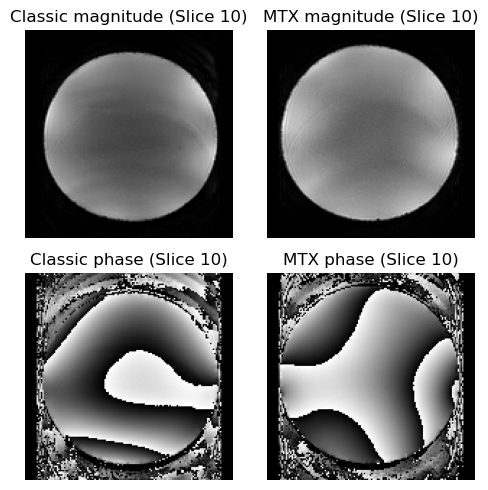

In [29]:
# Plot this now

# fig, ax = plt.subplots()
# ax.imshow(imgm_cla[:,:,10,1].T, origin='lower', cmap='gray')
# ax.axis(False)
# plt.show()

slice_index = 10
time_point = 1

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(5, 5))  # Adjust figsize as needed

# Plot imgm_cla
axs[0, 0].imshow(imgm_cla[:, :, slice_index, time_point].T, origin='lower', cmap='gray')
axs[0, 0].set_title(f'Classic magnitude (Slice {slice_index})')  # Set subplot title with slice index
axs[0, 0].axis(False)  # Turn off axis labels and ticks

# Plot imgm_mtx
axs[0, 1].imshow(imgm_mtx[:, :, slice_index, time_point].T, origin='lower', cmap='gray')
axs[0, 1].set_title(f'MTX magnitude (Slice {slice_index})')  # Set subplot title with slice index
axs[0, 1].axis(False)  # Turn off axis labels and ticks

# Plot imgp_cla
axs[1, 0].imshow(imgp_cla[:, :, slice_index, time_point].T, origin='lower', cmap='gray')
axs[1, 0].set_title(f'Classic phase (Slice {slice_index})')  # Set subplot title with slice index
axs[1, 0].axis(False)  # Turn off axis labels and ticks

# Plot imgp_mtx
axs[1, 1].imshow(imgp_mtx[:, :, slice_index, time_point].T, origin='lower', cmap='gray')
axs[1, 1].set_title(f'MTX phase (Slice {slice_index})')  # Set subplot title with slice index
axs[1, 1].axis(False)  # Turn off axis labels and ticks

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

The iSNR calculation `ukat` performs is $\textrm{iSNR} = \frac{Mean\left(\textrm{Foreground Voxels}\right)}{\sigma\left
(\textrm{Background Voxels}\right)} \times \sqrt{2 - \frac{\pi}{2}}$. To do this we need to segment the image into
background and foreground voxels.
This mask can either be supplied manually or estimated by the `Isnr` class. Let's start by demonstrating the simplest way
the `Isnr` class can work before exploring the automatic background segmentation in more depth.

In [31]:
isnr_cla = snr.Isnr(imgm_cla, imgm_cla_affine).isnr
isnr_mtx = snr.Isnr(imgm_mtx, imgm_mtx_affine).isnr

print(f'Classic image has an iSNR of {isnr_cla:.2f}.')
print(f'MTX image has an iSNR of {isnr_mtx:.2f}.')

Classic image has an iSNR of 45.12.
MTX image has an iSNR of 83.11.


Additionally, iSNR maps can be generated. These are calculated by dividing the image by the standard deviation of the noise and multiplying it by the Rician correction factor. This is useful for visualising the noise in the image.

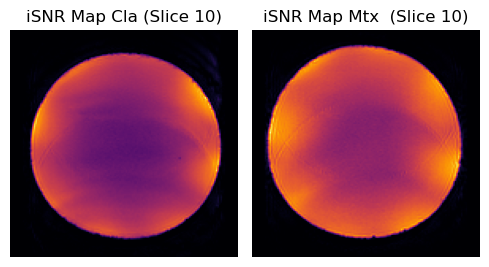

In [36]:
#isnr_obj = snr.Isnr(data, affine, n_clusters=2)
isnr_obj_cla = snr.Isnr(imgm_cla, imgm_cla_affine)
isnr_obj_mtx = snr.Isnr(imgm_mtx, imgm_mtx_affine)


# im = ax.imshow(isnr_obj_cla.isnr_map[:,:,slice_index, time_point].T, origin='lower', cmap='inferno')
# cb = fig.colorbar(im, ax=ax)
# cb.set_label('iSNR')
# ax.axis(False)
# ax.set_title('iSNR Map')

# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(5, 5))  # Adjust figsize as needed

# Plot imgm_cla
im_cla = axs[0].imshow(isnr_obj_cla.isnr_map[:,:,slice_index, time_point].T, origin='lower', cmap='inferno')
axs[0].set_title(f'iSNR Map Cla (Slice {slice_index})')  # Set subplot title with slice index
axs[0].axis(False)  # Turn off axis labels and ticks
cb = fig.colorbar(im, ax=ax)
cb.set_label('iSNR')

# Plot imgm_mtx
im_mtx = axs[1].imshow(isnr_obj_mtx.isnr_map[:,:,slice_index, time_point].T, origin='lower', cmap='inferno')
axs[1].set_title(f'iSNR Map Mtx  (Slice {slice_index})')  # Set subplot title with slice index
axs[1].axis(False)  # Turn off axis labels and ticks
cb = fig.colorbar(im, ax=ax)
cb.set_label('iSNR')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


## Temporal Signal to Noise Ratio (tSNR)
Here we will use two datasets as examples of high and low tSNR. Both are FAIR ASL sequences however the high tSNR data was
acquired a body coil while the low tSNR data was acquired using the receive coil built into the bore of the magnet. Additional Gaussian noise was also added to the low tSNR data.

Each dataset will be fetched, a tSNR map calculated and the output saved as a nifti. The resulting tSNR maps will also be displayed in this notebook.

(-0.5, 143.5, 143.5, -0.5)

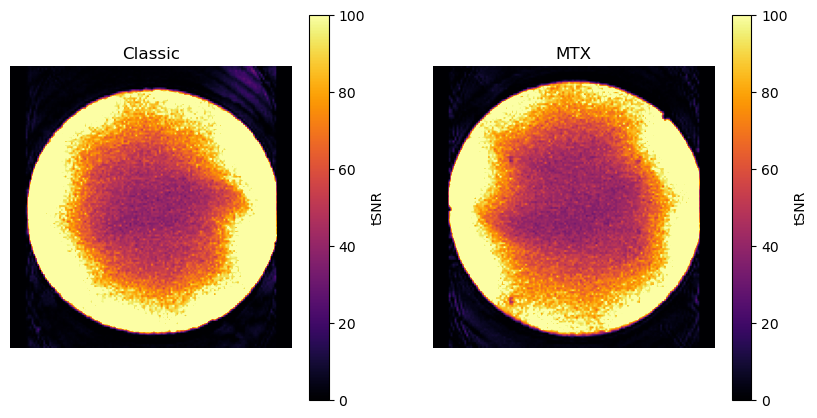

In [46]:
# need to remove noise scan
imgm_cla_nn = imgm_cla[:, :, :, :-1]  # Exclude the last volume along the time dimension
imgm_mtx_nn = imgm_mtx[:, :, :, :-1]  # Exclude the last volume along the time dimension


tsnr_obj_cla = snr.Tsnr(imgm_cla_nn, imgm_cla_affine)
tsnr_obj_cla.to_nifti(OUTPUT_DIR, 'classic_tsnr')
tsnr_obj_mtx = snr.Tsnr(imgm_mtx_nn, imgm_mtx_affine)
tsnr_obj_mtx.to_nifti(OUTPUT_DIR, 'mtx_tsnr')

# Display both tSNR maps in the same figure with the same colour scale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
im = ax1.imshow(np.rot90(tsnr_obj_cla.tsnr_map[:, :, 2]), cmap='inferno', clim=(0, 100))
cb = fig.colorbar(im, ax=ax1)
cb.set_label('tSNR')
ax1.set_title('Classic')
ax1.axis('off')

im = ax2.imshow(np.rot90(tsnr_obj_mtx.tsnr_map[:, :, 2], -1), cmap='inferno', clim=(0, 100))
cb = fig.colorbar(im, ax=ax2)
cb.set_label('tSNR')
ax2.set_title('MTX')
ax2.axis('off')

Just try plotting the timeseries and std

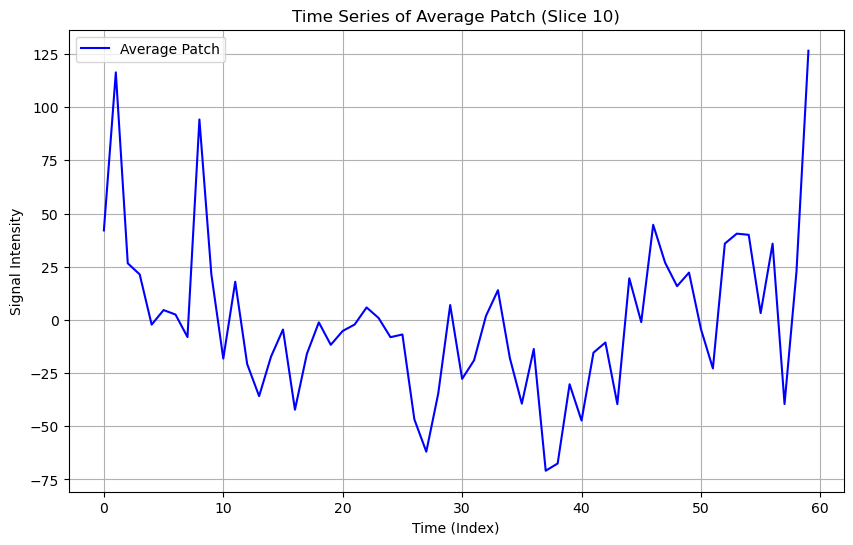

In [47]:
# Define the slice index to extract
from scipy.signal import detrend
slice_index = 10  # Adjust this to the desired slice index
time_points_index = 2  # Index of the time dimension (4th dimension) in imgm_cla

# Extract the 2D slice at the specified index from the 3D image data
slice_data = imgm_cla_nn[:, :, slice_index,:]

# Calculate the average signal intensity across the entire 2D slice over time
average_patch = np.mean(slice_data, axis=(0, 1))

# Detrend the average patch time series
detrended_patch = detrend(average_patch)

# Prepare the time points (x-axis) for the time series plot
time_points = np.arange(slice_data.shape[time_points_index])  # Array representing time points (61 time points)

# Plot the time series of the average patch
plt.figure(figsize=(10, 6))  # Adjust figsize as needed
plt.plot(time_points, detrended_patch, color='blue', label='Average Patch')

# Set plot title and labels
plt.title(f"Time Series of Average Patch (Slice {slice_index})")
plt.xlabel("Time (Index)")
plt.ylabel("Signal Intensity")
plt.legend()

# Show the plot
plt.grid(True)  # Enable grid for better visualization
plt.show()